## <b><font color='darkblue'>Preface</font></b>
([source course](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/3/langgraph-components)) <b><font size='3ptx'>[LangGraph](https://langchain-ai.github.io/langgraph/) is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. ([more](https://langchain-ai.github.io/langgraph/))</font></b>

<b>Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence.</b> LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions. <b>As a very low-level framework, it provides fine-grained control over both the flow and state of your application, crucial for creating reliable agents</b>. Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features.

![langgraph intro](images/ch3_1.png)

In [4]:
!pip freeze | grep -P '(openai|langchain|langgraph)'

langchain==0.2.6
langchain-anthropic==0.1.15
langchain-community==0.2.6
langchain-core==0.2.10
langchain-experimental==0.0.62
langchain-google-genai==1.0.6
langchain-groq==0.1.3
langchain-openai==0.1.9
langchain-text-splitters==0.2.0
langchainhub==0.1.14
langgraph==0.1.4
openai==1.28.1


In [7]:
import os
import openai
import re
import httpx
import os
from dotenv import load_dotenv, find_dotenv

from openai import OpenAI
from langchain_openai import ChatOpenAI

a = load_dotenv(find_dotenv(os.path.expanduser('~/.env'))) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [8]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [10]:
# You have to export environment variable `TAVILY_API_KEY`
# For details, refer to: https://app.tavily.com/home
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


## <b><font color='darkblue'>Use LangGraph to cretea an Agent</font></b>
<b><font size='3ptx'>One of the central concepts of LangGraph is state.</font> Each graph execution creates a state that is passed between nodes in the graph as they execute, and each node updates this internal state with its return value after it executes. </b>

The way that the graph updates its internal state is defined by either the type of graph chosen or a custom function. Let's take a look at a simple example of an agent that can search the web using [**Tavily Search API**](https://tavily.com/).

### <b><font color='darkgreen'>Step-by-step Breakdown</font></b>
* **Initialize the model and tools.**: We use ChatOpenAI as our LLM. NOTE: we need make sure the model knows that it has these tools available to call. We can do this by converting the LangChain tools into the format for OpenAI tool calling using the <font color='blue'>.bind_tools()</font> method ([LangChain doc: Passing tools to model](https://python.langchain.com/v0.1/docs/modules/model_io/chat/function_calling/#request-passing-tools-to-model)).
* **Initialize graph with state:**
  * We initialize graph ([**StateGraph**](https://langchain-ai.github.io/langgraph/reference/graphs/#stategraph)) by passing state schema (<font color='brown'>in our case</font> <font color='blue'>**AgentState**</font>)
  * <font color='blue'>**AgentState**</font> is a prebuilt state schema that has one attribute -- a list of LangChain [**BaseMessage**](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.base.BaseMessage.html#langchain_core.messages.base.BaseMessage) objects, as well as logic for merging the updates from each node into the state.
* **Define graph nodes:**
  * The `agent` node: responsible for deciding what (if any) actions to take.
  * The `tools` node that invokes tools: if the agent decides to take an action, this node will then execute that action.
* **Define entry point and graph edges**: First, we need to set the entry point for graph execution - agent node. Then we define one normal and one conditional edge. Conditional edge means that the destination depends on the contents of the graph's state (MessageState). In our case, the destination is not known until the agent (LLM) decides.
  * Conditional edge: after the agent is called, we should either:
    *  Run tools if the agent said to take an action, OR
    *  Finish (respond to the user) if the agent did not ask to run tools
  * Normal edge: after the tools are invoked, the graph should always return to the agent to decide what to do next
* **Compile the graph**:
  * When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling `.invoke()`, `.stream()` and `.batch()` with your inputs
  * We can also optionally pass checkpointer object for persisting state between graph runs, and enabling memory, human-in-the-loop workflows, time travel and more. In our case we use MemorySaver - a simple in-memory checkpointer
* **Execute the graph**
  * LangGraph adds the input message to the internal state, then passes the state to the entrypoint node, `"agent"`.
  * The `"agent"` node executes, invoking the chat model.
  * The chat model returns an [**AIMessage**](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.ai.AIMessage.html). LangGraph adds this to the state.
  * Graph cycles the following steps until there are no more `tool_calls` on [**AIMessage**](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.ai.AIMessage.html):
    * If [**AIMessage**](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.ai.AIMessage.html) has `tool_calls`, `"tools"` node executes
    * The `"agent"` node executes again and returns [**AIMessage**](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.ai.AIMessage.html)
    * Execution progresses to the special `END` value and outputs the final state. And as a result, we get a list of all our chat messages as output.

In [12]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

<b><font color='orange'>Note</font></b>: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [13]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

Let's test our agent to see how it works. Before that, let's check the graph of our agent:

In [16]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

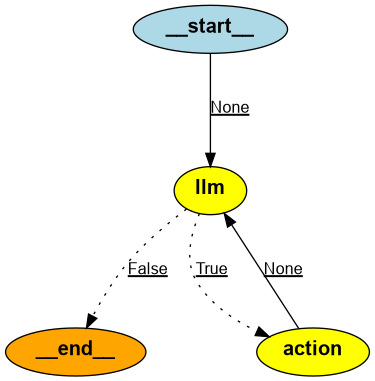

In [18]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

### <b><font color='darkgreen'>Question: `What is the weather in Taiwan?`</font></b>

In [19]:
messages = [HumanMessage(content="What is the weather in Taiwan?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Taiwan'}, 'id': 'call_sVKsfMEbKYtnxQy2c2tpJFoZ'}
Back to the model!


In [23]:
result

{'messages': [HumanMessage(content='What is the weather in Taiwan?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sVKsfMEbKYtnxQy2c2tpJFoZ', 'function': {'arguments': '{"query":"weather in Taiwan"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 153, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0887efcb-5d74-4740-bcde-2df3e6d0ad02-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Taiwan'}, 'id': 'call_sVKsfMEbKYtnxQy2c2tpJFoZ'}], usage_metadata={'input_tokens': 153, 'output_tokens': 20, 'total_tokens': 173}),
  ToolMessage(content='[{\'url\': \'https://www.accuweather.com/en/tw/taipei-city/315078/january-weather/315078\', \'content\': \'Get the monthly weather forecast for Taipei City, Taipei City, Taiwan, including daily high/low, hist

In [25]:
# Get last message:
print(result['messages'][-1].content)

The current weather in Taiwan, specifically in Taipei City, is partly cloudy with a temperature of 32.1°C (89.8°F). The wind speed is 15.1 kph coming from the south, with a humidity of 67%. The forecast indicates a feels-like temperature of 35.2°C (95.4°F) with no precipitation.


### <b><font color='darkgreen'>Question: `What is the weather in Taiwan and Japan?`</font></b>

In [26]:
messages = [HumanMessage(content="What is the weather in Taiwan and Japan?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Taiwan'}, 'id': 'call_Od42hseZU7DK8Hu1AOHbAitt'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Japan'}, 'id': 'call_m7AkHELmJpTKwaazZC84cja0'}
Back to the model!


In [28]:
# Show the last message:
print(result['messages'][-1].content)

The current weather in Taiwan is partly cloudy with a temperature of 32.1°C (89.8°F). The wind speed is 16.9 kph coming from the SSW direction. The humidity is 67% with a UV index of 8.0.

In Japan, specifically in Tokyo, it is partly cloudy with a temperature of 29.2°C (84.6°F). The wind speed is 13.0 kph from the SSW direction. The humidity is 79% with a UV index of 8.0.

Both Taiwan and Japan are experiencing hot temperatures during July with some rainy days expected.


### <b><font color='darkgreen'>Question: `Who won the super bowl in 2024? In what state is the winning team headquarters located? What is the GDP of that state? Answer each question.`</font></b>

In [29]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_pP1NqbsFncCjCSUdcgHm8PSR'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters state'}, 'id': 'call_pP1NqbsFncCjCSUdcgHm8PSR'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2023'}, 'id': 'call_Mj84Icl3eRNaIvpWALkfBmGJ'}
Back to the model!


In [31]:
# Get the last message:
print(result['messages'][-1].content)

The GDP of Missouri in 2023 was approximately $344.12 billion.

To summarize:
1. The Kansas City Chiefs won the Super Bowl in 2024.
2. The Kansas City Chiefs' headquarters are located in Missouri.
3. The GDP of Missouri in 2023 was approximately $344.12 billion.


## <b><font color='darkblue'>Supplement</font></b>
* [Deeplearn.ai - AI Agents in LangGraph - Ch2: Build an Agent from Scratch](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/2/build-an-agent-from-scratch)
* [YWC 科技筆記 - LangGraph: LangChain Agent 的殺手鐧 (入門)](https://ywctech.net/ml-ai/langchain-langgraph-agent-part1/)
* [FAQ - Pip install pygraphviz fails: Failed building wheel for pygraphviz](https://stackoverflow.com/questions/40266604/pip-install-pygraphviz-fails-failed-building-wheel-for-pygraphviz)